# Импорт необходимых библиотек

In [15]:
import pandas as pd
import re
import seaborn as sns
from tqdm import tqdm_notebook

from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AutoModelForSequenceClassification

import time

from tqdm.notebook import tqdm

# Загрузка данных

In [16]:
df_original = pd.read_csv('train_dataset_train.csv')
df_original.head()

,id,Текст Сообщения,Тематика,Ответственное лицо,Категория
0,2246,Помогите начальник Льговского рэс не реагирует...,"Нарушения, связанные с содержанием электросети...",Администрация Льговского района,3
1,380,<p>По фасаду дома по адресу ул. Урицкого 22 пр...,Аварийные деревья,Администрация города Курска,3
2,2240,Агресивные собаки. На радуге там стая из подро...,Безнадзорные животные,Администрация города Курска,1
3,596,<p>На пересечении &nbsp;улиц Сосновская и Бере...,Нескошенная сорная растительность в местах общ...,Комитет дорожного хозяйства города Курска,3
4,1797,<p style=`text-align:justify;`><span style=`ba...,Аварийные деревья,Комитет городского хозяйства города Курска,3


In [17]:
df_aug = pd.read_csv('train_aug_bert_model.csv')
df_aug.head()

,text,tema,bailee,categories
0,< p > Добрый день. & nbsp ; < / p > < p > по о...,Пешеходные переходы на дорогах в границах горо...,Комитет природных ресурсов Курской области,0
1,"Напомним, в д. Старый Свет уже 3 дня не чистят...",Очистка от снега и наледи дорог в границах гор...,Администрация Железногорского района,0
2,< p > Детский день. просят помощи в решении на...,Нарушение дорожного покрытия (ямы) на дорогах...,Комитет городского хозяйства города Курска,0
3,< 380 > Минска & 2 ; < / en >,Нарушение дорожного покрытия (ямы) на дорогах...,Комитет дорожного хозяйства города Курска,0
4,< p > Добрый день. Сегодня 17. 08. 2021 напрот...,Пешеходные переходы на дорогах в границах горо...,Комитет дорожного хозяйства города Курска,0


In [18]:
df_org = df_original[['Текст Сообщения', 'Категория']]
df_org.columns = ['text', 'target']
df_aug = df_aug[['text', 'categories']]
df_aug.columns = ['text', 'target']

In [19]:
df_aug_train, df_aug_test = train_test_split(df_aug, test_size=0.2, random_state=42)
print(df_aug_train.shape, df_aug_test.shape)

(11344, 2) (2836, 2)


In [20]:
df_train = pd.concat([df_org, df_aug_train])

<AxesSubplot:xlabel='target', ylabel='count'>

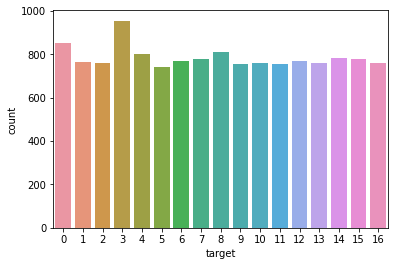

In [21]:
# посмотрим на баланс классов, после разделения на тренировочные и проверочные
sns.countplot(x='target', data=df_train)

In [22]:
## очистим данные от тегов, чисел, знаков припинания
def preprocessing_text(text):
    text = text.lower()
    text = re.sub(r'\<[^>]*\>', '', text)
    text = re.sub(r'[a-zA-Z]', '', text)
    text = re.sub(r'\d', '', text)
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', text)
    text = re.sub('\s+', ' ', text)
    return text

In [23]:
df_train['text'] = df_train['text'].apply(preprocessing_text)
df_aug_test['text'] = df_aug_test['text'].apply(preprocessing_text)

# Создание DataLoder

In [30]:
model_name1 = 'DeepPavlov/rubert-base-cased'

In [31]:
tokenizer = AutoTokenizer.from_pretrained(model_name1)
max_length = 500

In [32]:
class MessageDataset(Dataset):
    def __init__(self, dataset=df_train, tokenizer=tokenizer, max_length=max_length):
        self.message = dataset['text'].tolist()
        self.target = dataset['target'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.message[idx]
        target = self.target[idx]
        
        tokenizer_output = self.tokenizer.encode_plus(text,
                                          max_length=self.max_length,
                                          padding="max_length",
                                          return_tensors="pt"
                                         )        
        return {
            "input_ids": tokenizer_output['input_ids'][0][:self.max_length], 
            "mask": tokenizer_output['attention_mask'][0][:self.max_length],
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.target)

In [33]:
train_dataset = MessageDataset(dataset=df_train)
valid_dataset = MessageDataset(dataset=df_aug_test)

In [34]:
batch_size = 8

In [35]:
train_dataloader = DataLoader(
                                train_dataset, 
                                batch_size=batch_size,
                                #num_workers=16
                                )

test_dataloader = DataLoader(
                                valid_dataset, 
                                batch_size=batch_size,
                                #num_workers=16
                                )

# Обучение модели 

In [36]:
device = "cuda" if torch.cuda.is_available else "cpu"

In [37]:
model_1 = AutoModelForSequenceClassification.from_pretrained(model_name1)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

In [38]:
model_1.classifier = nn.Linear(in_features=768, out_features=17, bias=True)

In [39]:
model_1 = model_1.to(device)

In [40]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in tqdm(enumerate(iterator)):      
        
        input_batch = batch['input_ids'].to(device)
        mask_batch = batch['mask'].to(device)
        labels = batch['target'].to(device)        
        optimizer.zero_grad()
        
        output = model(input_ids=input_batch, attention_mask=mask_batch).logits        
        loss = criterion(output, labels) 
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())

        
    return epoch_loss / (i + 1)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in tqdm(enumerate(iterator)):

            input_batch = batch['input_ids'].to(device)
            mask_batch = batch['mask'].to(device)
            labels = batch['target'].to(device)
            
            output = model(input_ids=input_batch, attention_mask=mask_batch).logits
            
            loss = criterion(output, labels)
            
            epoch_loss += loss.item()
        
    return epoch_loss / (i + 1)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [41]:
lr = 1e-6
optimizer = torch.optim.AdamW(model_1.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

In [43]:
train_history = []
valid_history = []

N_EPOCHS = 5
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model_1, train_dataloader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model_1, test_dataloader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_1.state_dict(), 'best-val-model_bert_full2.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

1668it [11:39,  2.38it/s]
355it [00:43,  8.17it/s]


Epoch: 01 | Time: 12m 23s
	Train Loss: 0.069
	 Val. Loss: 0.076


1668it [11:38,  2.39it/s]
355it [00:42,  8.26it/s]


Epoch: 02 | Time: 12m 21s
	Train Loss: 0.058
	 Val. Loss: 0.087


1668it [11:39,  2.39it/s]
355it [00:42,  8.27it/s]


Epoch: 03 | Time: 12m 22s
	Train Loss: 0.050
	 Val. Loss: 0.079


1668it [11:14,  2.47it/s]
355it [00:43,  8.11it/s]


Epoch: 04 | Time: 11m 58s
	Train Loss: 0.046
	 Val. Loss: 0.081


1668it [11:41,  2.38it/s]
355it [00:43,  8.25it/s]

Epoch: 05 | Time: 12m 24s
	Train Loss: 0.034
	 Val. Loss: 0.079
